In [1]:
#Align and crop face
import cv2
import pandas as pd
from helpers.face import Face
from helpers.image_reader import read_image
from preprocessors.asymmetry_calculator import process_all_face

group_directories = {'PD','HC'}
group_directory = 'PD'
output_signal_folder = f'./data/working/csv-new-signal/'
version = 'v4'


In [2]:
from helpers.load_data_subject_csv import create_dataset
parkinson_df, control_df = create_dataset(output_signal_folder, 'PD', 'HC')
data = pd.concat([parkinson_df, control_df], axis=0)
data = data.sample(frac=1,random_state=12)
#Create dataset for train
data = data.set_index('user')
X = data.drop(['label'], axis=1)
y = data['label']
X = X.fillna(method='bfill')

C:\Users\atefe\AppData\Local\Temp\ipykernel_34396\302553974.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='bfill')


In [144]:
import joblib
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from helpers.feature_selection import select_features_PCA, select_features_RFE


#X_filtered = X.filter(regex='(Feature4|Feature6|Feature13|Feature16)_')
# X_filtered = X_filtered.filter(regex='_diameter')
#X_filtered = X.filter(regex='^(mean|standard_deviation|skewness|kurtosis|max|median|min|amplitude|variance)_')
X_filtered=X
X_scaled = StandardScaler().fit_transform(X_filtered)
selector = RFECV(estimator=LogisticRegression(), step=2, cv=5)
#selector = RFE(estimator=LogisticRegression(), n_features_to_select=18)
X_selected = selector.fit_transform(X_scaled, y)
selected_features_mask = selector.support_
selected_feature_names = X_filtered.columns[selected_features_mask]

model_placeholder = Pipeline([
    ('model', LogisticRegression())  # Placeholder for the model
])

# Define the parameter grid
param_grid = [
    # Logistic Regression
    {
         'model': [LogisticRegression(max_iter=10000)],
         'model__C': [0.1, 1,10],
    },
    # Random Forest Classifier
    {
        'model': [RandomForestClassifier()],
         'model__n_estimators': [100, 200],
         'model__max_features': ['log2', 'sqrt'],
    },
    #SVC
    {
        'model': [SVC()],
        'model__C': [0.1,0.5, 1,2, 10],
        'model__kernel': ['linear', 'rbf'],
    },
    #DecisionTreeClassifier
    {
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [5,10,15],
    },
    # XGBoost Classifier
    {
        'model': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        'model__n_estimators': [200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [4],
        'model__subsample': [0.8],  # Subsample ratio of the training instances
        'model__colsample_bytree': [0.9],  # Subsample ratio of columns when constructing each tree
    },
    
]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=22)
grid_search = GridSearchCV(model_placeholder, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_selected, y)
# Now, to access the best estimator and its parameters:
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best parameters: {'model': SVC(), 'model__C': 0.1, 'model__kernel': 'linear'}
Best Score: 0.8904761904761905


In [145]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Assuming X_train, X_test, y_train, y_test are already defined as per your code
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
# Use the best_model to make predictions on the test set
y_pred = best_model.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

print(report)
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        23
           1       0.89      0.89      0.89        19

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42

Precision: 0.9047619047619048
Recall: 0.9047619047619048
F1-Score: 0.9047619047619048


In [146]:
selected_feature_names

Index(['skewness_whole_norm',
       'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1_whole_norm',
       'IQR_whole_vertically', 'min_whole_vertically',
       'CO_trev_1_num_whole_vertically',
       'MD_hrv_classic_pnn40_whole_vertically',
       'SB_BinaryStats_mean_longstretch1_whole_vertically',
       'CO_Embed2_Dist_tau_d_expfit_meandiff_whole_vertically',
       'IN_AutoMutualInfoStats_40_gaussian_fmmi_whole_vertically',
       'rms_asymmetry_norm_line', 'skewness_asymmetry_norm_line',
       'kurtosis_asymmetry_norm_line',
       'DN_OutlierInclude_p_001_mdrmd_asymmetry_norm_line',
       'SB_BinaryStats_diff_longstretch0_asymmetry_norm_line',
       'IQR_asymmetry_vertically_line', 'kurtosis_asymmetry_vertically_line',
       'DN_HistogramMode_5_asymmetry_vertically_line',
       'CO_FirstMin_ac_asymmetry_vertically_line',
       'SB_BinaryStats_diff_longstretch0_asymmetry_vertically_line',
       'IQR_asymmetry_norm_eye', 'skewness_asymmetry_norm_eye',
       'DN_HistogramMode_5_asy

In [147]:
#grid_search.cv_results_
best_index = grid_search.best_index_
fold_accuracies = grid_search.cv_results_[f'split0_test_score'][best_index], \
                  grid_search.cv_results_[f'split1_test_score'][best_index], \
                  grid_search.cv_results_[f'split2_test_score'][best_index], \
                  grid_search.cv_results_[f'split3_test_score'][best_index], \
                  grid_search.cv_results_[f'split4_test_score'][best_index]

print("Accuracies of the best model on each CV fold:", fold_accuracies)
std_of_best_score = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print("Standard Deviation of Best Score:", std_of_best_score)

Accuracies of the best model on each CV fold: (0.8571428571428571, 0.9285714285714286, 0.9523809523809523, 0.8809523809523809, 0.8333333333333334)
Standard Deviation of Best Score: 0.04416008807378905


In [24]:
#Save the model
joblib.dump(selected_feature_names, f'models/selected_features_{version}.pkl')
joblib.dump(best_model , f'models/best_model_{version}.pkl')

['models/best_model_v4.pkl']

In [81]:
# Predict on the test set using the best model
y_pred = best_model.predict(X_selected)

# Calculate and print the accuracy on the test set
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy on Test Set: {accuracy}")

Accuracy on Test Set: 1.0


In [82]:
import numpy as np
indexes = np.where(y_pred != y)
#print user column of y_test where the prediction is wrong
y.iloc[indexes]


Series([], Name: label, dtype: int64)

In [57]:
# Extract columns that include the name 'mean'
from scipy import stats


mean_columns = data.filter(regex='^(IQRn)_')
# Prepare for statistical analysis
results = {}

for column in mean_columns.columns:
    # Splitting the data based on label
    group_0 = data[data['label'] == 0][column]
    group_1 = data[data['label'] == 1][column]
    
    # Perform a t-test to see if there's a significant difference between the two groups
    # Note: This assumes the data is normally distributed and the variances are equal
    # For non-normal data, consider using Mann-Whitney U test instead
    stat, p_value = stats.ttest_ind(group_0, group_1)
    
    # Store the result
    if(p_value < 0.05):
        results[column] = p_value

#sorted results
results = dict(sorted(results.items(), key=lambda item: item[1]))
results

{'IQRn_asymmetry_vertically_mouth': 0.0057713607622065155,
 'IQRn_asymmetry_vertically_nose': 0.038873206859424525,
 'IQRn_asymmetry_norm_line': 0.039406643411918456,
 'IQRn_whole_norm': 0.04068289547715901,
 'IQRn_whole_vertically': 0.044538217240921475}

In [162]:
from scipy.stats import mannwhitneyu
import numpy as np

mean_columns =  data.filter(regex='^(IQRf)_')
# Prepare for statistical analysis
results_mwu = {}

for column in mean_columns.columns:
    # Splitting the data based on label
    group_0 = data[data['label'] == 0][column]
    group_1 = data[data['label'] == 1][column]
    
    # Perform a Mann-Whitney U test to see if there's a significant difference between the two groups
    stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    #print mean and std of each group
    print(f'{column}:', 'HC:', group_0.mean(), group_0.std(), 'PD:', group_1.mean(), group_1.std())
    # Store the result
    if(p_value < 0.1):
        results_mwu[column] = p_value

    # Store the result if p-value is less than 0.05

results = dict(sorted(results_mwu.items(), key=lambda item: item[1]))
results

IQRf_whole_norm: HC: 0.43813501735834376 0.8728573970291086 PD: 0.9711898954271004 1.9561558407202342
IQRf_whole_vertically: HC: 0.7375273553037426 1.2502562459315336 PD: 1.3344712578131037 3.672190519473033
IQRf_asymmetry_norm_line: HC: 0.21388695590768333 0.4605903098760668 PD: 0.5335986127469665 1.0618501198742387
IQRf_asymmetry_vertically_line: HC: 0.3823668391148772 0.5510550328834508 PD: 0.6866950679113079 1.7861896738100724
IQRf_asymmetry_norm_eye: HC: 0.23448394898389846 0.4530959796160837 PD: 0.4605101181015336 0.8341027834935171
IQRf_asymmetry_vertically_eye: HC: 4.374782092569477 17.398140977574812 PD: 3.400645995313577 33.90174378689268
IQRf_asymmetry_norm_eyebrow: HC: 0.2530887330180011 0.44631033273627724 PD: 0.44689860271690024 0.7466716643916351
IQRf_asymmetry_vertically_eyebrow: HC: 4.895601161647894 18.82648174152773 PD: 5.584804062284739 70.22712546621572
IQRf_asymmetry_norm_mouth: HC: 0.17635932050267256 0.3324960281504423 PD: 0.3742511914516386 0.7124869694377015
I

{'IQRf_asymmetry_vertically_mouth': 0.0055126125775751674,
 'IQRf_asymmetry_norm_mouth': 0.014859670418563302,
 'IQRf_asymmetry_norm_line': 0.031489790772047464,
 'IQRf_asymmetry_norm_nose': 0.06632226546854998,
 'IQRf_whole_norm': 0.08137298570569103}

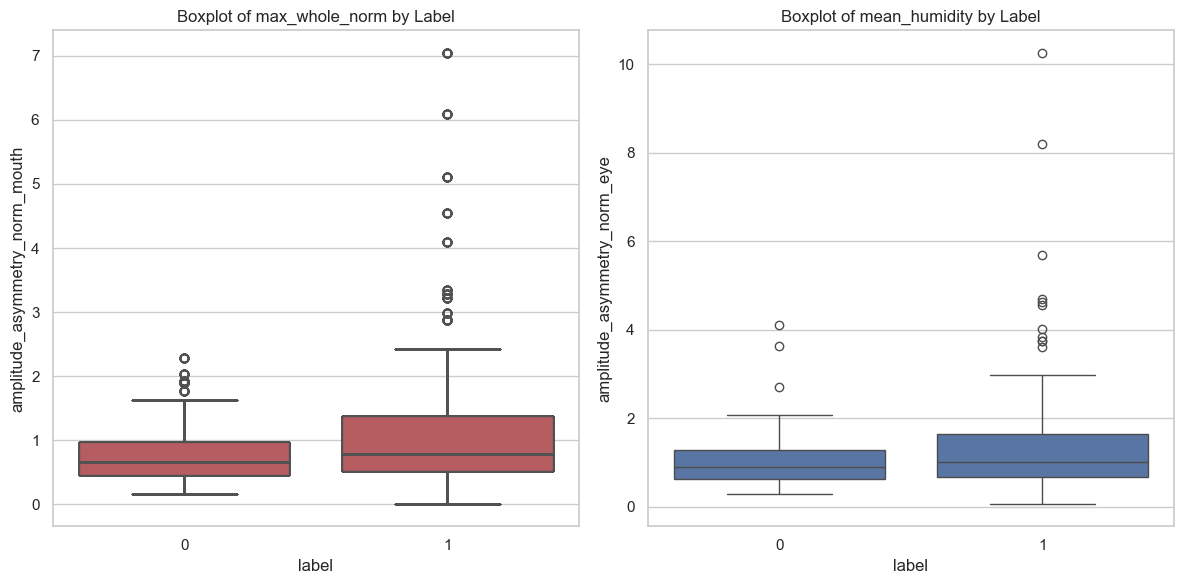

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Creating box and whisker plots to show differences in 'mean_temperature' and 'mean_humidity' between the two groups
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for key, value in results.items():
    # Plot for 'mean_temperature'
    sns.boxplot(ax=axes[0], x='label', y='amplitude_asymmetry_norm_mouth', data=data)
    axes[0].set_title('Boxplot of max_whole_norm by Label')

# Plot for 'mean_humidity'
sns.boxplot(ax=axes[1], x='label', y='amplitude_asymmetry_norm_eye', data=data)
axes[1].set_title('Boxplot of mean_humidity by Label')

plt.tight_layout()
plt.show()

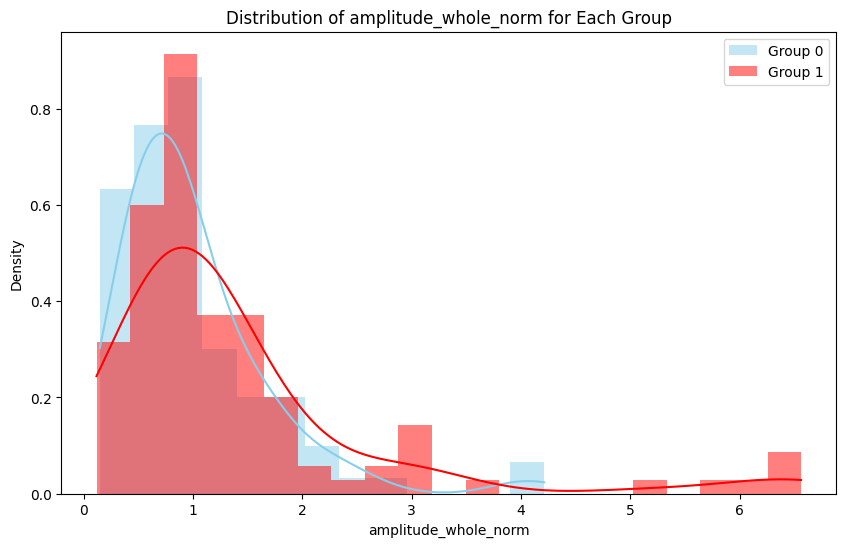

Shapiro-Wilk Test:
Statistic: 0.8114802837371826, P-value: 9.832498149009439e-10
D'Agostino's K-squared Test:
Statistic: 60.33498955809156, P-value: 7.914500021584451e-14
Skewness: 2.14816898602095
Kurtosis: 6.394983170618762
At least one test suggests the data may not be normally distributed.


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, skew, kurtosis
import numpy as np

# Example column name - replace 'your_column_name' with the actual column name you want to plot
column_name = 'amplitude_whole_norm'

# Creating the figure and axis for the plot
plt.figure(figsize=(10, 6))

# Plotting the distribution for group 0
sns.histplot(data[data['label'] == 0][column_name], color="skyblue", label='Group 0', kde=True, stat="density", linewidth=0)

# Plotting the distribution for group 1
sns.histplot(data[data['label'] == 1][column_name], color="red", label='Group 1', kde=True, stat="density", linewidth=0)

# Adding some plot aesthetics
plt.title(f'Distribution of {column_name} for Each Group')
plt.xlabel(column_name)
plt.ylabel('Density')
plt.legend()

# Display the plot
plt.show()



# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(data[data['label'] == 0][column_name])
# D'Agostino's K-squared test
dagostino_stat, dagostino_p = normaltest(data[data['label'] == 0][column_name])

# Skewness and Kurtosis
data_skew = skew(data[data['label'] == 0][column_name])
data_kurtosis = kurtosis(data[data['label'] == 0][column_name])

# Results
print(f"Shapiro-Wilk Test:\nStatistic: {shapiro_stat}, P-value: {shapiro_p}")
print(f"D'Agostino's K-squared Test:\nStatistic: {dagostino_stat}, P-value: {dagostino_p}")
print(f"Skewness: {data_skew}\nKurtosis: {data_kurtosis}")

# Interpretation of the results
if shapiro_p > 0.05 and dagostino_p > 0.05:
    print("Both tests suggest the data is normally distributed.")
else:
    print("At least one test suggests the data may not be normally distributed.")

# Note: Interpretation is based on the common alpha level of 0.05. Adjust according to your specific needs.



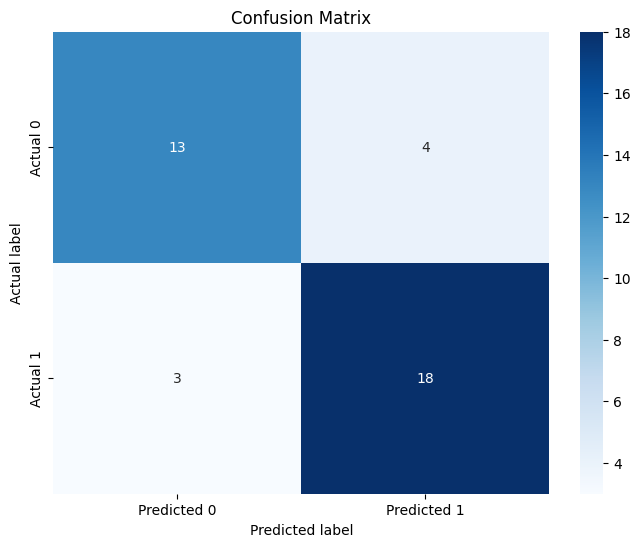

Accuracy: 0.8158
Precision: 0.8182
Recall: 0.8571
F1 Score: 0.8372


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

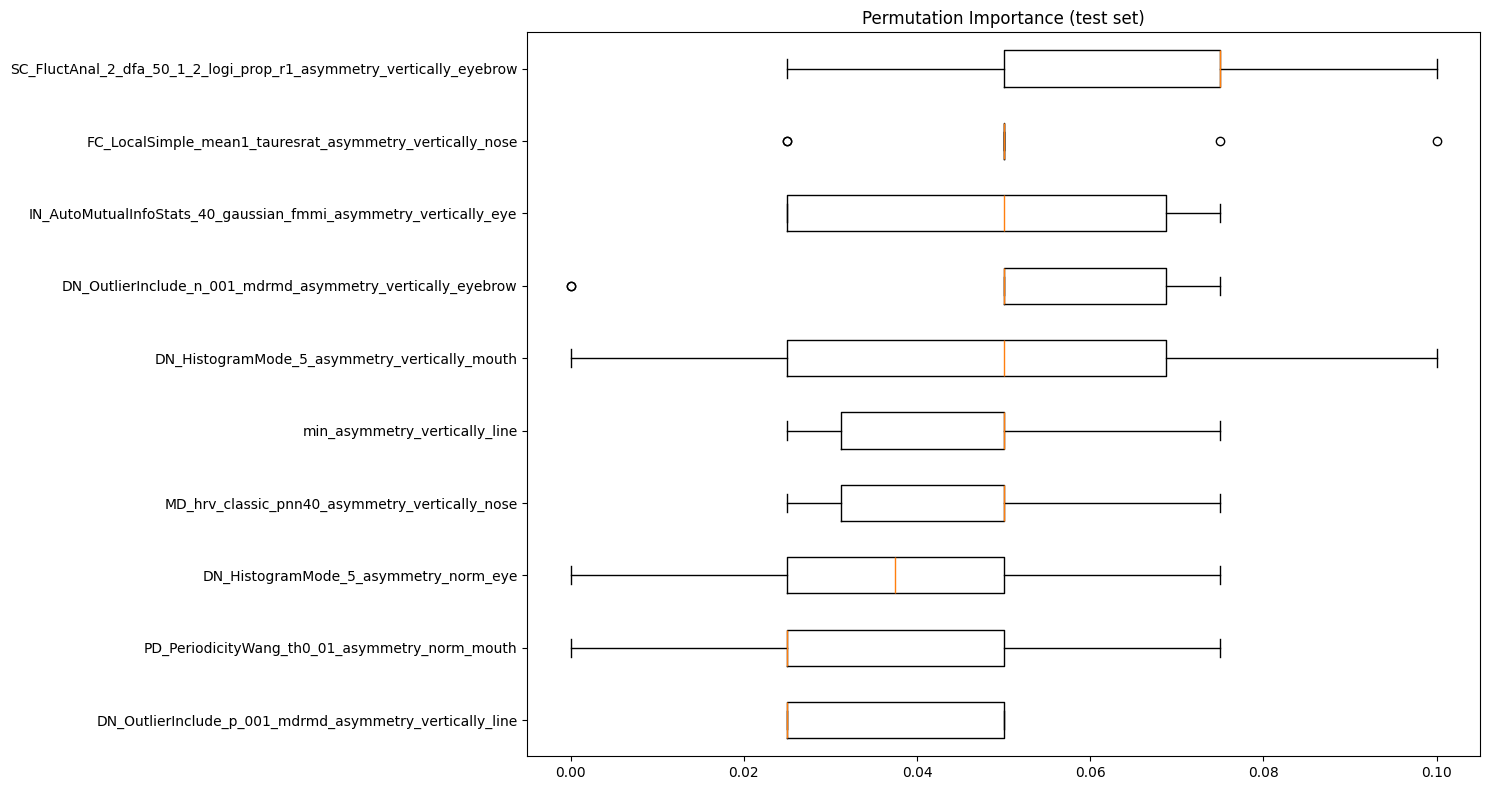

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
# Example: Using the Iris dataset
from sklearn.datasets import load_iris

# Compute permutation feature importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plot the importances
sorted_idx = result.importances_mean.argsort()
sorted_idx = sorted_idx[-10:]
fig, ax = plt.subplots(figsize=(15,8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(selected_feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.tight_layout()
plt.show()


In [2]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from helpers.load_data_subject_csv import  load_data
import pandas as pd
# Function to normalize dataframes
def normalize_df(df):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df)
    df_normalized = pd.DataFrame(scaled_values, index=df.index, columns=df.columns)
    return df_normalized,scaler

angry_folder = f'./data/working/emotions/normal/angry'
angry_df = load_data(angry_folder, 1)

sad_folder = f'./data/working/emotions/normal/sad'
sad_df = load_data(sad_folder, 1)


disgust_folder = f'./data/working/emotions/normal/disgust'
disgust_df = load_data(disgust_folder, 1)


happy_folder = f'./data/working/emotions/normal/happy'
happy_df = load_data(happy_folder, 1)

angry_df = angry_df.filter(regex='^amplitude.*norm.*')
sad_df = sad_df.filter(regex='^amplitude.*norm.*')
happy_df = happy_df.filter(regex='^amplitude.*norm.*')
disgust_df = disgust_df.filter(regex='^amplitude.*norm.*')

# angry_df,angry_scaler = normalize_df(angry_df)
# sad_df,sad_scaler = normalize_df(sad_df)
# happy_df,happy_scaler = normalize_df(happy_df)
# disgust_df,disgust_scaler = normalize_df(disgust_df)

normal_df = pd.concat([happy_df, sad_df, angry_df, disgust_df], ignore_index=True,axis=1)
normal_df,normal_scaler = normalize_df(normal_df)
dfs = [happy_df, sad_df,angry_df, disgust_df]
normal_means = []
dfs= [happy_df, sad_df,angry_df, disgust_df]
for df in dfs:
    mean = df.median()
    normal_means.append(mean)
    
    